In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster

import matplotlib.pyplot as plt
import cartopy
import cmocean
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils

import metpy.calc as mpcalc

#### Define case and path

In [2]:
variables = ['PH','DIC','DIC_ALT_CO2','coccoC','diatC','TEMP','spC','coccoCaCO3']
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = ['dz','KMT','time_bound'] + variables + list(coords.values())

#### Get grid

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

### Get the variables

In [4]:
%%time

ds = xr.Dataset()

for v in variables:  
    print(v)
    files = f'{path}/{case}.pop.h.{v}.195801-202112.nc'

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                   drop_variables=["transport_components", "transport_regions"], combine='nested',decode_times=True)

    ds = xr.merge((ds, dsv))

ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()

PH
DIC
DIC_ALT_CO2
coccoC
diatC
TEMP
spC
coccoCaCO3
CPU times: user 3.97 s, sys: 151 ms, total: 4.12 s
Wall time: 6.56 s


In [5]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [6]:
ds

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 384, nlon: 320, time: 768, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time         (time) object 1958-01-16 13:00:00.000001 ... 2021-12-16 12:0...
Dimensions without coordinates: d2, nlat, nlon, z_t, z_t_150m
Data variables:
    KMT          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    PH           (time, nlat, nlon) float32 dask.array<chunksize=(768, 384, 320), meta=np.ndarray>
    dz           (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bound   (time, d2) object dask.array<chunksize=(768, 2), meta=np.ndarray>
    DIC          (time, z_t, nlat, nlon) float32 dask.array<chunksize=(768, 60, 384, 320), meta=np.ndarray>
    DIC_ALT_CO2  (time, z_t, nlat, nlon) float32 dask.array<chunksize=(768, 60, 384, 320), meta=np.ndarray>
    coccoC       (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(768, 15, 384, 320), meta=np.ndarray>
    diatC        (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(768, 15, 384, 320), meta=np.ndarray>
    TEMP         (time, z_t, nlat, nlon) float32 dask.array<chunksize=(768, 60, 384, 320), meta=np.ndarray>
    spC          (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(768, 15, 384, 320), meta=np.ndarray>
    coccoCaCO3   (time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(768, 15, 384, 320), meta=np.ndarray>

In [7]:
box1_latmin = 38.84
box1_latmax = 67.64
box1_lonmin = -60.04
box1_lonmax = 7.56

### Just need surface variables

In [8]:
ds=ds.isel(z_t_150m=0)
ds=ds.isel(z_t=0)

### Find July 2005

In [9]:
ds.time[570]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2005, 7, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2005-07-16 12:00:00

In [10]:
cocco_bloom = ds.coccoC.isel(time=570)

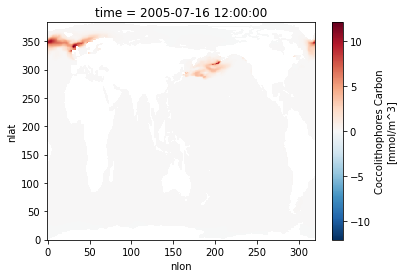

In [11]:
cocco_bloom.plot()

### spin up dask

In [12]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='01:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [13]:
# cluster, client = get_ClusterClient()
# cluster.scale(12) 
# client

## Regional average timeseries

In [14]:
variables = ['coccoC','coccoCaCO3','PH','DIC','DIC_ALT_CO2','TEMP']

In [15]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [16]:
ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

In [17]:
ds_regmean = xr.Dataset()

for var in variables:
    mask = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
    masked_area = area.where(mask==1).where(ds_grid.REGION_MASK>0)

    masked_fosi = ds_ann[var]

    ds_regmean[var] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
ds_regmean = ds_regmean.load()

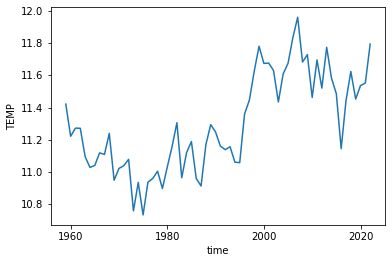

In [18]:
ds_regmean.TEMP.plot()

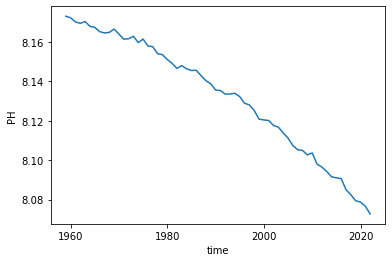

In [19]:
ds_regmean.PH.plot()

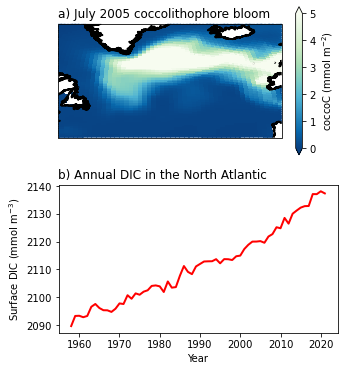

In [20]:
fig = plt.figure(figsize=(5,6))

############### 
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

ax.set_title('a) July 2005 coccolithophore bloom', loc='left')

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, cocco_bloom)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='GnBu_r',
                   vmin=0,vmax=5)
ax.coastlines('10m',linewidth=2)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='coccoC (mmol m$^{-2}$)')
    
############### 
ax = fig.add_subplot(2,1,2)

ax.set_title('b) Annual DIC in the North Atlantic', loc='left')

ax.plot(np.arange(1958,2022,1),ds_regmean.DIC, linewidth=2, color='red')
ax.set(xlabel='Year',ylabel='Surface DIC (mmol m$^{-3}$)');

In [21]:
ds_ann.time.isel(time=slice(-5,64))

<xarray.DataArray 'time' (time: 5)>
array([cftime.DatetimeNoLeap(2017, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2019, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2020, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2021, 12, 31, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 2017-12-31 00:00:00 ... 2021-12-31 00:00:00

In [22]:
picpoc1 = (ds_ann.coccoCaCO3.isel(time=slice(0,5)).mean(dim='time'))/(ds_ann.coccoC.isel(time=slice(0,5)).mean(dim='time'))

In [23]:
picpoc2 = (ds_ann.coccoCaCO3.isel(time=slice(-5,64)).mean(dim='time'))/(ds_ann.coccoC.isel(time=slice(-5,64)).mean(dim='time'))

In [24]:
picpoc_diff = picpoc2 - picpoc1

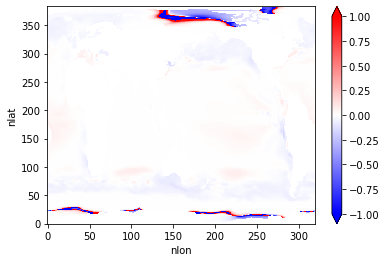

In [25]:
picpoc_diff.plot(vmin=-1,vmax=1,cmap='bwr')

In [26]:
ph1 = ds_ann.PH.isel(time=slice(0,5)).mean(dim='time')
ph2 = ds_ann.PH.isel(time=slice(-5,64)).mean(dim='time')

In [27]:
ph_diff = ph2 - ph1

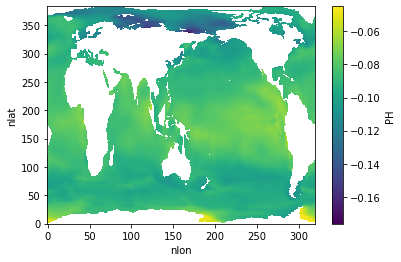

In [28]:
ph_diff.plot()

In [29]:
temp1 = ds_ann.TEMP.isel(time=slice(0,5)).mean(dim='time')
temp2 = ds_ann.TEMP.isel(time=slice(-5,64)).mean(dim='time')

In [30]:
temp_diff = temp2 - temp1

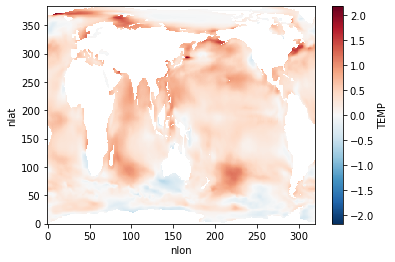

In [31]:
temp_diff.plot()

In [32]:
import matplotlib.gridspec as gridspec

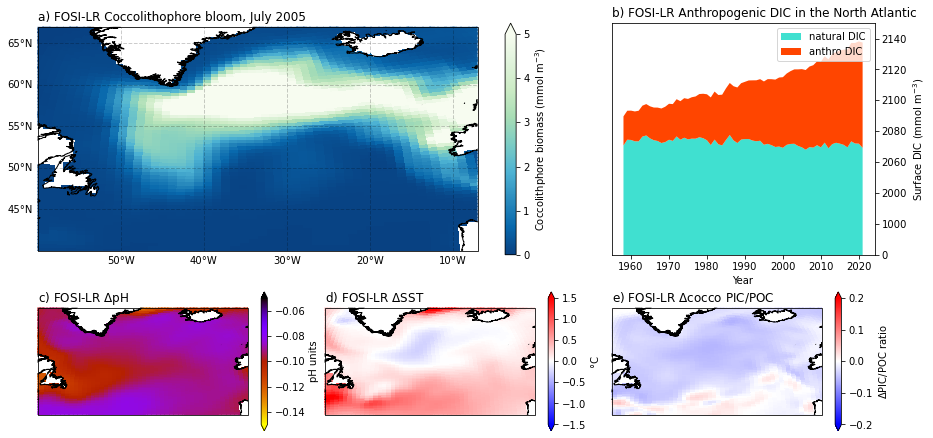

In [34]:
fig = plt.figure(figsize=(15, 7.5))

gs = gridspec.GridSpec(nrows=2, ncols=6, width_ratios=(1, 1, 1, 1, 1,1), height_ratios=(1,0.6))

prj = ccrs.PlateCarree()

ax_bloom = plt.subplot(gs[0,0:4], projection=prj)
ax_dicts = plt.subplot(gs[0,4:6])

ax_dPH = plt.subplot(gs[1, 0:2], projection=prj)
ax_dT = plt.subplot(gs[1, 2:4], projection=prj)
ax_dpicpoc = plt.subplot(gs[1, 4:6], projection=prj)

### Cocco bloom
ax_bloom.set_title('a) FOSI-LR Coccolithophore bloom, July 2005', loc='left')
ax_bloom.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, cocco_bloom)

pc = ax_bloom.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='GnBu_r',
                   vmin=0,vmax=5)
ax_bloom.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_bloom,extend='max',label='Coccolithphore biomass (mmol m$^{-3}$)')
gl = ax_bloom.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False
    
    
########### dic timeseries

ax_dicts.set_title('b) FOSI-LR Anthropogenic DIC in the North Atlantic', loc='left')

#ax_dicts.plot(np.arange(1958,2022,1),ds_x01_regmean.DIC-ds_x01_regmean.DIC_ALT_CO2, linewidth=2, color='red')

ax_dicts.stackplot(np.arange(1958,2022,1),ds_regmean.DIC_ALT_CO2,ds_regmean.DIC-ds_regmean.DIC_ALT_CO2, labels=["natural DIC","anthro DIC"], colors=['turquoise','orangered'])
ax_dicts.set_ylim(2000,2150)

labels = ['0','1000','2000','2060', '2080', '2100','2120','2140']
ax_dicts.set_yticklabels(labels)

ax_dicts.set(xlabel='Year',ylabel='Surface DIC (mmol m$^{-3}$)');
ax_dicts.yaxis.set_label_position("right")
ax_dicts.yaxis.tick_right()
ax_dicts.legend()


### pH change
ax_dPH.set_title('c) FOSI-LR ${\Delta}$pH', loc='left')
ax_dPH.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, ph_diff)

pc = ax_dPH.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='gnuplot_r',
                   vmin=-0.15,vmax=-0.05)
ax_dPH.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_dPH,extend='both',label='pH units')

### TEMP change
ax_dT.set_title('d) FOSI-LR ${\Delta}$SST', loc='left')
ax_dT.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, temp_diff)

pc = ax_dT.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-1.5,vmax=1.5)
ax_dT.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_dT,extend='both',label='°C')

### picpoc change
ax_dpicpoc.set_title('e) FOSI-LR ${\Delta}$cocco PIC/POC', loc='left')
ax_dpicpoc.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, picpoc_diff)

pc = ax_dpicpoc.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-0.2,vmax=0.2)
ax_dpicpoc.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_dpicpoc,extend='both',label='${\Delta}$PIC/POC ratio')

fig.savefig('/glade/work/kristenk/figs/OA_coccofig_x1.png', bbox_inches='tight', dpi=300, format='png');

### How much does pH drop globally ?

In [5]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

In [6]:
def preprocess(ds):
    ds=ds.isel(z_t_150m=0)
    ds=ds.isel(z_t=0)
    return ds

In [8]:
%%time

ds1 = xr.Dataset()

for v in ['PH']: 
    print(v)
    keep_vars = [v] +['dz','KMT','TLAT','TLONG','z_t_150m','z_t','time','time_bound']
    
    dsv = xr.Dataset()
    
    for year in np.arange(1958,1963,1):
        yr4="{:04d}".format(year)

        print(year)

        files = sorted(glob(f'{path}/{case}.pop.h.{v}.{yr4}??-{yr4}??.nc'))
        
        ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)

        ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars]).squeeze()
        ds_tmp = ds_tmp.mean(dim='time')
        dsv= xr.concat([dsv,ds_tmp],'time')
    ds1 = xr.merge([ds1,dsv])

PH
1958
1959
1960
1961
1962
CPU times: user 2.34 s, sys: 406 ms, total: 2.75 s
Wall time: 3.43 s


In [9]:
%%time

ds2 = xr.Dataset()

for v in ['PH']: 
    print(v)
    keep_vars = [v] +['dz','KMT','TLAT','TLONG','z_t_150m','z_t','time','time_bound']
    
    dsv = xr.Dataset()
    
    for year in np.arange(2017,2022,1):
        yr4="{:04d}".format(year)

        print(year)

        files = sorted(glob(f'{path}/{case}.pop.h.{v}.{yr4}??-{yr4}??.nc'))
        
        ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)

        ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars]).squeeze()
        ds_tmp = ds_tmp.mean(dim='time')
        dsv= xr.concat([dsv,ds_tmp],'time')
    ds2 = xr.merge([ds2,dsv])

PH
2017
2018
2019
2020
2021
CPU times: user 2.36 s, sys: 427 ms, total: 2.79 s
Wall time: 4.2 s


In [10]:
ds1= ds1.mean(dim='time')

In [11]:
ds2= ds2.mean(dim='time')

In [12]:
ph_diff = ds2.PH - ds1.PH

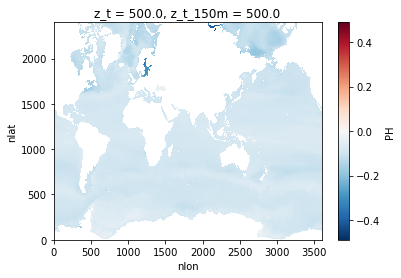

In [13]:
ph_diff.plot()

In [14]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

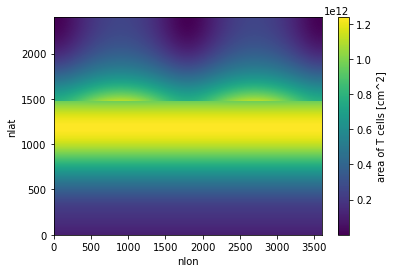

In [15]:
area.plot()

In [17]:
global_mean_ph_change = (ph_diff * area).sum(dim=('nlon','nlat'))/area.sum(dim=('nlon','nlat'))

In [18]:
global_mean_ph_change.values

array(-0.06458879)